<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#FUNCIONES" data-toc-modified-id="FUNCIONES-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>FUNCIONES</a></span></li><li><span><a href="#IMPORTAR-DATOS" data-toc-modified-id="IMPORTAR-DATOS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>IMPORTAR DATOS</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#variables-numericas" data-toc-modified-id="variables-numericas-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>variables numericas</a></span></li><li><span><a href="#variable-temporales" data-toc-modified-id="variable-temporales-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>variable temporales</a></span></li><li><span><a href="#has-collection" data-toc-modified-id="has-collection-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>has collection</a></span></li><li><span><a href="#original_language" data-toc-modified-id="original_language-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>original_language</a></span></li><li><span><a href="#frecuencias" data-toc-modified-id="frecuencias-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>frecuencias</a></span></li><li><span><a href="#numero-estrellas" data-toc-modified-id="numero-estrellas-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>numero estrellas</a></span></li></ul></li><li><span><a href="#Keywords_independent-film" data-toc-modified-id="Keywords_independent-film-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Keywords_independent film</a></span><ul class="toc-item"><li><span><a href="#Movies-in-english" data-toc-modified-id="Movies-in-english-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Movies in english</a></span></li><li><span><a href="#Cast_freq" data-toc-modified-id="Cast_freq-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Cast_freq</a></span></li></ul></li><li><span><a href="#production-companies" data-toc-modified-id="production-companies-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>production companies</a></span></li><li><span><a href="#Feature-engineer" data-toc-modified-id="Feature-engineer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature engineer</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import RobustScaler


#Automcompletar rápido
%config IPCompleter.greedy=True

from xgboost import XGBRegressor


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

C:\Users\acrespod\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\acrespod\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import seaborn as sns

# FUNCIONES

In [3]:
def frecuencias_series(series, lista_posible, grafico=False):
    """series: serie con elementos en string separados por comas
        lista_posible: todas las posibles strings en series
        """
    aux = pd.Series( dtype='float64')
    for elemento in list(lista_posible):
    
        n = series.apply(lambda x:  elemento in x).sum()/2100*100
        aux = pd.concat([aux,pd.Series({elemento:n})] )
    if grafico:
        aux.sort_values().plot.barh()
    return aux.sort_values()


def lista_posibles(series):
    aux = series.map(lambda x: sorted([d['name'] for d in get_dictionary(x)]))
    generos = set()
    for f in aux:
        generos.update(f)
    return generos



def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

def get_temp_var(df_cat):
    a = df_cat.release_date.dt.year
    b = df_cat.release_date.dt.month
    c = df_cat.release_date.dt.dayofweek
    d = df_cat.release_date.dt.quarter
    x = pd.concat([a,b,c,d],axis=1)
    x.columns = ['rd_year', 'rd_mes', 'rd_dia_semana', 'rd_cuatrimestre']
    return x


def conteo_genero(serie):
    aux = []
    for numero in [0,1,2]:
        x = serie.apply(lambda lista: lista.count(numero))
        aux.append(x)
    df_aux = pd.concat(aux,axis=1)
    df_aux.columns = ['cast_genero_0','cast_genero_1','cast_genero_2']
    return df_aux



In [4]:
def procesamiento(cat):
    cat = cat.copy()
    #ELIMINAR
    a_eliminar = ['belongs_to_collection','homepage','imdb_id','poster_path','tagline','spoken_languages',]
    cat.drop(columns=a_eliminar,inplace=True)

    #IMPUTACION
    cat.genres.fillna('OTRO', inplace=True)
    cat.production_companies.fillna('OTRO',inplace=True)
    cat.production_countries.fillna('OTRO',inplace=True)
    cat.Keywords.fillna('OTRO',inplace=True)
    cat.cast.fillna('OTRO',inplace=True)
    cat.crew.fillna('OTRO',inplace=True)

    cat.release_date = pd.to_datetime(cat.release_date)



    # LISTA VARIABLES
    lista_vars =['genres','production_companies','production_countries','Keywords','cast','crew']
    no_transformadas = [v for v in cat.columns.tolist() if v not in lista_vars]
    no_transformadas

    #DF VARIABLES SIN JSONS
    aux = []
    for var in lista_vars:
        z = cat[var].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
        aux.append(z)


    df_limpios = pd.concat(aux,axis=1)



    #DF FRECUENCIAS DE VARIABLES LIMPIAS
    aux = []
    for column in df_limpios.columns:
        z = df_limpios[column].map(lambda x: len(x.split(',')))
        aux.append(z)
    df_freq = pd.concat(aux,axis=1)
    df_freq.columns = [var+"_freq" for var in df_freq.columns]
    df_freq

    # VARIABLES TIEMPO
    df_temp = get_temp_var(cat)
    df_temp['rd_year'] = np.where(df_temp['rd_year']>2020,df_temp['rd_year']-100,df_temp['rd_year'])

    # frecuencia genero
    z = cat['cast'].map(lambda x: sorted([d['gender'] for d in get_dictionary(x)]))
    df_cast_genero_freq = conteo_genero(z)    
    
    
    # UNIR TODOS LOS DATASETS
    df_cat = pd.concat([cat[no_transformadas],df_temp,df_limpios,df_freq,df_cast_genero_freq],axis=1)


    # VARIABLES NUEVA WINSORIZADO
    df_cat['bin_english'] = np.where(df_cat.original_language=='en',1,0) 
    df_cat['genres_freq'] = np.where(df_cat['genres_freq']>4,4,df_cat['genres_freq'])
    df_cat['production_companies_freq'] = np.where(df_cat['production_companies_freq']>4,4,df_cat['production_companies_freq'])
    df_cat['production_countries_freq'] = np.where(df_cat['production_countries_freq']>1,1,0)


    variable = 'Keywords_freq'
    minimo = 0
    maximo = 35
    df_cat[variable].clip(minimo,maximo, inplace=True)

    variable = 'cast_freq'
    minimo = 0
    maximo = 85
    df_cat[variable].clip(minimo,maximo, inplace=True)

    variable = 'crew_freq'
    minimo = 0
    maximo = 135
    df_cat[variable].clip(minimo,maximo, inplace=True)
    return df_cat

In [5]:
def get_ohe_var_series(series,elemento):
    """series : series
        elemento :str
    """
    
    series_ohe = series.apply(lambda x: 1  if  elemento in x else 0 )
    series_ohe.name = series.name +"_"+elemento
    return series_ohe

def post_procesamiento_m1(_df_cat):

    diccionario_variables = {
        'production_countries':['United States of America'],
        'production_companies'  :['Paramount Pictures'],
        'Keywords':['freq_rs', 'independent film', 'murder']
        
    }

    aux = []
    for variable, terminos in diccionario_variables.items():

        for termino in terminos:
            z= get_ohe_var_series( _df_cat[variable],termino)
            aux.append(z)
            
    df_fei2 = pd.concat(aux,axis=1)
    df_cat2 = pd.concat([_df_cat,df_fei2],axis=1)


    return df_cat2

In [6]:
def pre_procesamiento(df):
    df = df.copy()
    
    mean = df.runtime.mean()
    df.runtime.fillna(mean,inplace=True)
    
    variable = 'runtime'
    minimo = 70
    maximo = 200

    df[variable].clip(minimo,maximo, inplace=True)

    variable = 'budget'
    minimo = 0
    maximo = 200000000

    df[variable].clip(minimo,maximo, inplace=True)

    variable = 'popularity'
    minimo = 0
    maximo = 50

    df[variable].clip(minimo,maximo, inplace=True)
    
    return df

# IMPORTAR DATOS

In [7]:
# DATOS ENTRENAMIENTO
ruta_proyecto =  'C:/proyectos/03_PREDICCION_TAQUILLA'
nombre_fichero_datos = 'train.csv'
ruta_completa = ruta_proyecto + '/02_Datos/01_Originales/' + nombre_fichero_datos

datos_train = pd.read_csv(ruta_completa)

In [8]:
cat = pre_procesamiento(datos_train)
df_cat =  procesamiento(cat)
df_cat2 = post_procesamiento_m1(df_cat)

In [9]:
df_cat2['log_revenue']=np.log1p(df_cat2['revenue'])

In [71]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                3000 non-null   float64
 15  spok

In [11]:
df_cat2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   id                                             3000 non-null   int64         
 1   budget                                         3000 non-null   int64         
 2   original_language                              3000 non-null   object        
 3   original_title                                 3000 non-null   object        
 4   overview                                       2992 non-null   object        
 5   popularity                                     3000 non-null   float64       
 6   release_date                                   3000 non-null   datetime64[ns]
 7   runtime                                        3000 non-null   float64       
 8   status                                         3000 non-nu

# EDA

## variables numericas

In [12]:
num = df_cat.select_dtypes('number').copy()

In [13]:
num.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         3000 non-null   int64  
 1   budget                     3000 non-null   int64  
 2   popularity                 3000 non-null   float64
 3   runtime                    3000 non-null   float64
 4   revenue                    3000 non-null   int64  
 5   rd_year                    3000 non-null   int64  
 6   rd_mes                     3000 non-null   int64  
 7   rd_dia_semana              3000 non-null   int64  
 8   rd_cuatrimestre            3000 non-null   int64  
 9   genres_freq                3000 non-null   int64  
 10  production_companies_freq  3000 non-null   int64  
 11  production_countries_freq  3000 non-null   int32  
 12  Keywords_freq              3000 non-null   int64  
 13  cast_freq                  3000 non-null   int64

In [67]:
num[['budget','runtime','revenue']].describe().T
# num.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,3000.0,2.223733e+07,3.523552e+07,0.0,0.00,8000000.0,29000000.0,2.000000e+08
runtime,3000.0,1.081056e+02,2.039493e+01,70.0,94.00,104.0,118.0,2.000000e+02
revenue,3000.0,6.672585e+07,1.375323e+08,1.0,2379808.25,16807068.0,68919203.5,1.519558e+09


**budget**: hay peliculas sin presupuesto

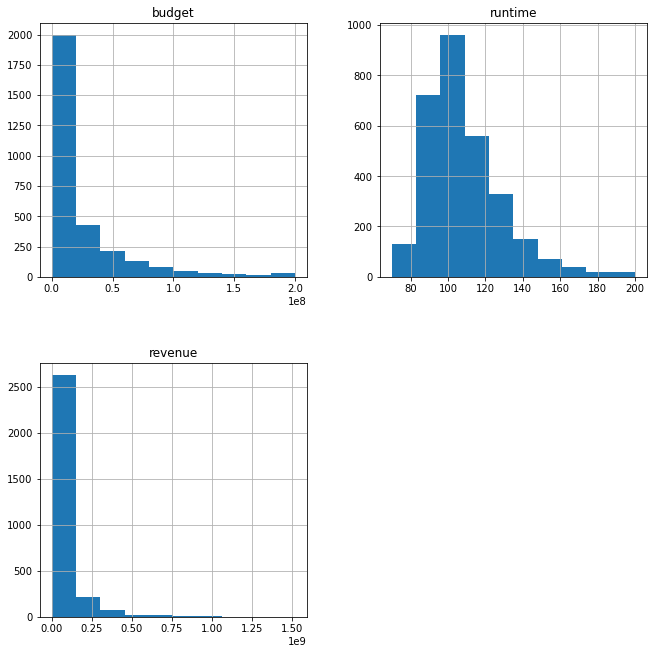

In [68]:
num[['budget','runtime','revenue']].hist( figsize=(10,10) )
plt.tight_layout(pad=4.0);

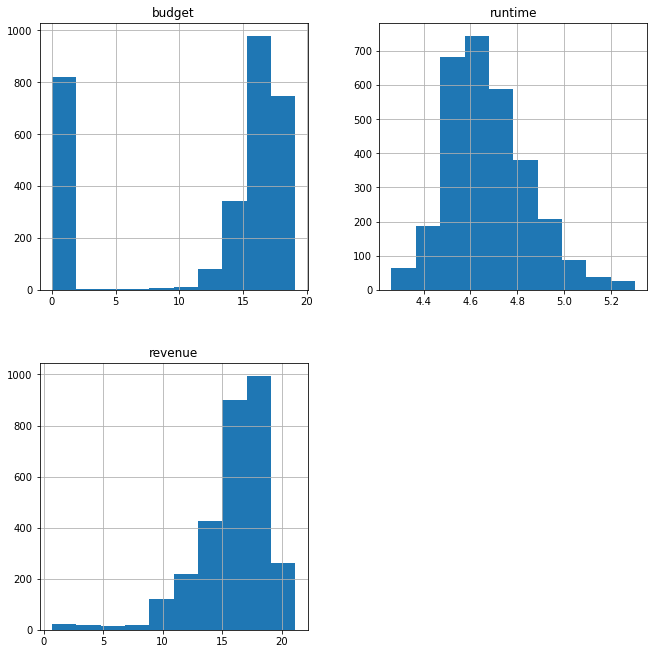

In [21]:
num[['budget','runtime','revenue']].transform(np.log1p).hist( figsize=(10,10) )
plt.tight_layout(pad=4.0);

In [70]:
#Numero de registros
num.query('budget==0 ')['budget'].count()


812

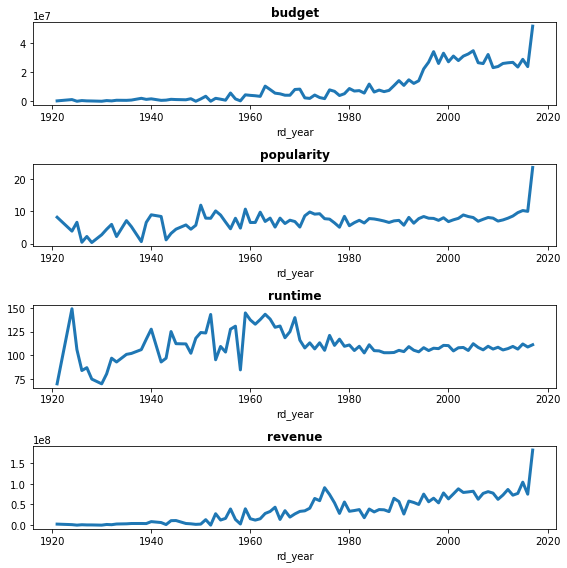

In [85]:
variables = ['budget','popularity','runtime','revenue' ]
fig, ax = plt.subplots(4, 1, tight_layout=True, figsize=(8,8))
ax = ax.flat
for numero, variable in enumerate(variables):
    df_cat.groupby('rd_year')[variable].mean().plot(ax=ax[numero], linewidth=3).set_title(variable, fontweight="bold")

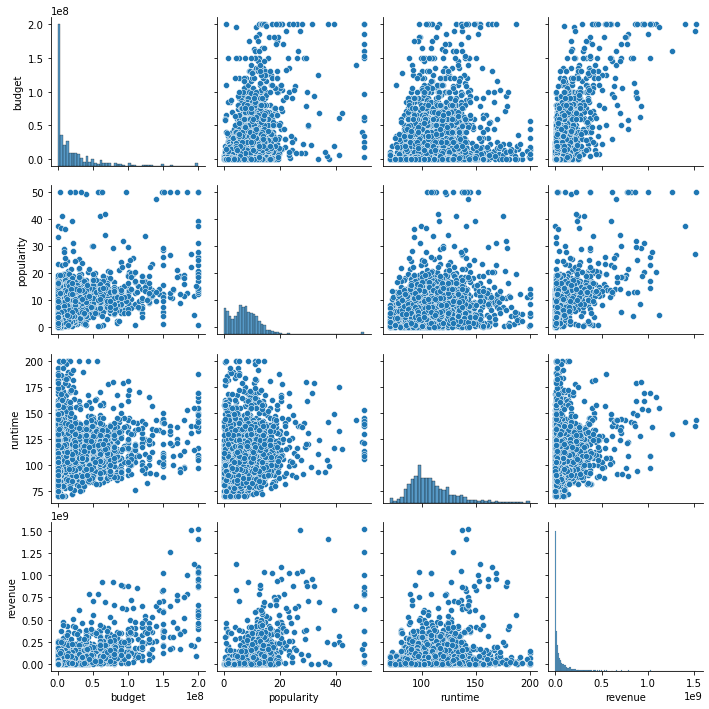

In [112]:
variables = ['budget','popularity','runtime','revenue' ]
num['budget'] = replace_low_budget_values(x=num, mapa_year_budget=mapa_year_budget, valor_limite=0)
sns.pairplot(df_cat[variables])

## variable temporales

In [88]:
num.columns

Index(['id', 'budget', 'popularity', 'runtime', 'revenue', 'rd_year', 'rd_mes',
       'rd_dia_semana', 'rd_cuatrimestre', 'genres_freq',
       'production_companies_freq', 'production_countries_freq',
       'Keywords_freq', 'cast_freq', 'crew_freq', 'cast_genero_0',
       'cast_genero_1', 'cast_genero_2', 'bin_english'],
      dtype='object')

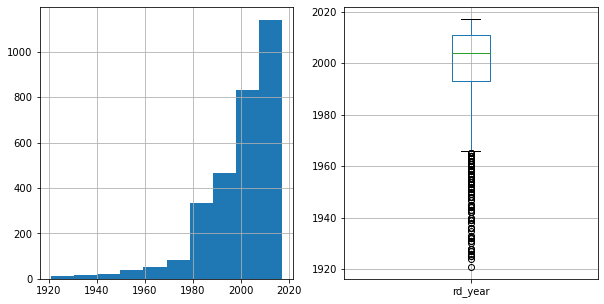

In [106]:
fig,ax= plt.subplots(1,2, figsize=(10,5))
ax=ax.flat
num['rd_year'].hist(ax=ax[0])
num.boxplot(column='rd_year',ax=ax[1]);

In [ ]:
'rd_year', 'rd_mes',
       'rd_dia_semana', 

<AxesSubplot:xlabel='rd_year'>

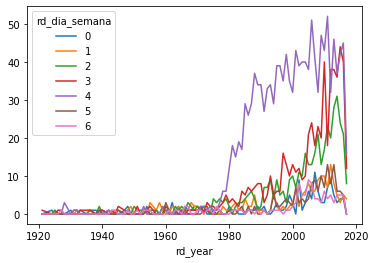

In [95]:
num.groupby(['rd_year', 'rd_dia_semana']).size().unstack(level=-1).fillna(0).plot()

## has collection

<AxesSubplot:xlabel='collection', ylabel='log_revenue'>

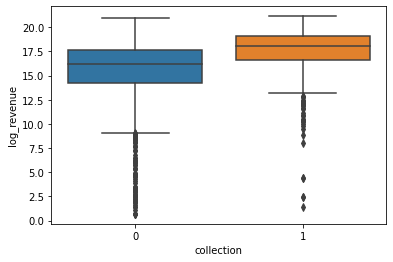

In [122]:

z = cat['belongs_to_collection'].fillna('').map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: 1 if len(x)>0 else 0)
df_cat2['collection']= z
sns.boxplot(data=df_cat2,x='collection',y='log_revenue')

## original_language

In [124]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         3000 non-null   int64         
 1   budget                     3000 non-null   int64         
 2   original_language          3000 non-null   object        
 3   original_title             3000 non-null   object        
 4   overview                   2992 non-null   object        
 5   popularity                 3000 non-null   float64       
 6   release_date               3000 non-null   datetime64[ns]
 7   runtime                    3000 non-null   float64       
 8   status                     3000 non-null   object        
 9   title                      3000 non-null   object        
 10  revenue                    3000 non-null   int64         
 11  rd_year                    3000 non-null   int64         
 12  rd_mes

<AxesSubplot:xlabel='original_language', ylabel='log_revenue'>

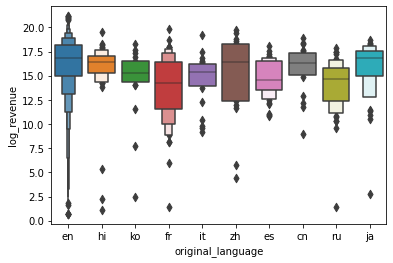

In [134]:
sns.boxenplot(data=df_cat2.loc[df_cat2['original_language'].isin(df_cat2['original_language'].value_counts().head(10).index)],\
                                                               x='original_language',y='log_revenue')

## frecuencias

In [163]:
variables = df_cat.columns[df_cat.columns.str.contains('_freq')].tolist()
variables

['genres_freq',
 'production_companies_freq',
 'production_countries_freq',
 'Keywords_freq',
 'cast_freq',
 'crew_freq']

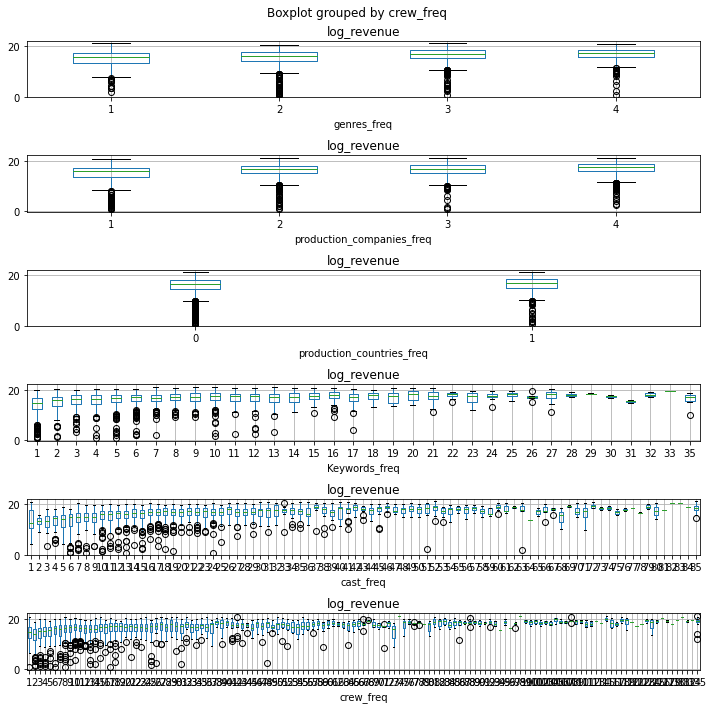

In [170]:
fig,ax= plt.subplots(6,1, figsize=(10,10))
ax=ax.flat
for numero,variable in enumerate(variables):

    df_cat2.boxplot(by=variable,column='log_revenue',ax=ax[numero])
fig.tight_layout(pad=1);

## numero estrellas

In [19]:
from collections import Counter
def get_series_stars( _df_cat,variable,lista_elementos):
    """INPUT
       OUTPUT"""
    series = _df_cat[variable].copy()
    
    
    aux = []
    for termino in lista_elementos:
        z= get_ohe_var_series( series,termino)
        aux.append(z)
    return pd.concat(aux,axis=1).apply(lambda x: x.sum(), axis=1)

def get_most_common_elements(_df_cat,variable,mas_comunes=50):
    
    series = _df_cat[variable].copy()
    
    data_aux = series.map(lambda x: x.split(',')) 

    contador = Counter([ elemento for fila in data_aux for elemento in fila if elemento not in  ['',' Jr.'] ]).most_common(mas_comunes)
    lista_elementos = [a for a,b in contador]
    return lista_elementos

In [21]:
lista_actores = get_most_common_elements(df_cat,variable='cast',mas_comunes=100)
df_stars_100=get_series_stars( df_cat,variable='cast',lista_elementos=lista_actores)
df_stars_100.name ='numero_estrellas'

<AxesSubplot:xlabel='numero_estrellas', ylabel='log_revenue'>

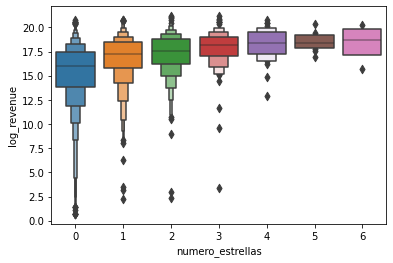

In [23]:
sns.boxenplot(x=df_stars_100,y=df_cat2['log_revenue'])

# Keywords_independent film

In [29]:
df_cat2.corr(method='kendall')['log_revenue'].sort_values()

Keywords_independent film                       -0.153563
rd_dia_semana                                   -0.076009
Keywords_murder                                  0.000857
id                                               0.005421
rd_year                                          0.015240
rd_cuatrimestre                                  0.017888
rd_mes                                           0.023486
production_countries_freq                        0.047676
cast_genero_0                                    0.067316
production_companies_Paramount Pictures          0.110519
genres_freq                                      0.166190
runtime                                          0.179099
bin_english                                      0.181373
production_companies_freq                        0.189827
Keywords_freq                                    0.232768
cast_genero_1                                    0.253182
production_countries_United States of America    0.270340
cast_freq     

<AxesSubplot:ylabel='Keywords_independent film'>

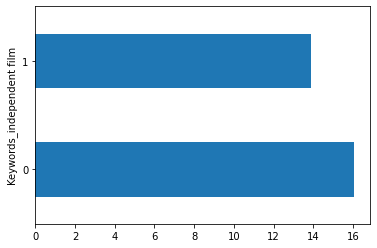

In [34]:
df_cat2.groupby(['Keywords_independent film'])['log_revenue'].agg('mean').plot.barh()

<AxesSubplot:xlabel='Keywords_independent film', ylabel='log_revenue'>

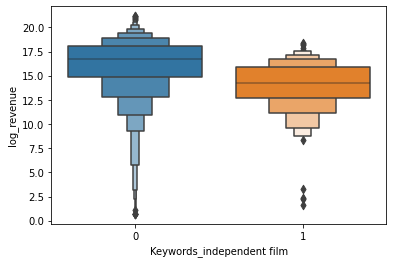

In [38]:
sns.boxenplot(data=df_cat2, x='Keywords_independent film',y='log_revenue')

## Movies in english

<AxesSubplot:ylabel='bin_english'>

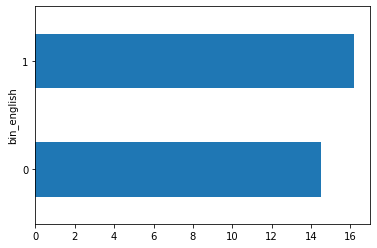

In [35]:
df_cat2.groupby(['bin_english'])['log_revenue'].agg('mean').plot.barh()

<AxesSubplot:xlabel='bin_english', ylabel='log_revenue'>

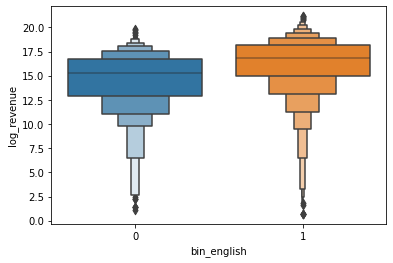

In [39]:
sns.boxenplot(data=df_cat2, x='bin_english',y='log_revenue')

## Cast_freq

<AxesSubplot:xlabel='cast_freq', ylabel='log_revenue'>

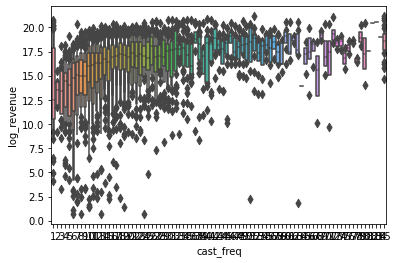

In [40]:
sns.boxenplot(data=df_cat2, x='cast_freq',y='log_revenue')

<AxesSubplot:xlabel='cast_freq'>

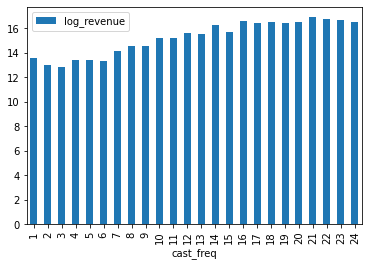

In [52]:
pd.DataFrame(df_cat2.groupby(['cast_freq'])['log_revenue'].agg('mean').sort_index()).query('cast_freq < 25').plot.bar()

# production companies

In [60]:
[elemento for fila in df_cat2.production_companies for elemento in fila.split(',') if elemento not in ['']]

['Metro-Goldwyn-Mayer (MGM)',
 'Paramount Pictures',
 'United Artists',
 'Walt Disney Pictures',
 'Blumhouse Productions',
 'Bold Films',
 'Right of Way Films',
 'Ghost House Pictures',
 'North Box Productions',
 'Jim Henson Company',
 ' The',
 'Jim Henson Productions',
 'Walt Disney Pictures',
 'Castle Rock Entertainment',
 'United Artists',
 'Amercent Films',
 'American Entertainment Partners L.P.',
 'Interscope Communications',
 'Twentieth Century Fox Film Corporation',
 'DreamWorks SKG',
 'Jinks/Cohen Company',
 'Double Feature Films',
 'Jersey Films',
 'Metro-Goldwyn-Mayer (MGM)',
 'Nina Saxon Film Design',
 'Amblin Entertainment',
 'Blue Tulip Productions',
 'Cruise/Wagner Productions',
 'Digital Image Associates',
 'DreamWorks SKG',
 'Ronald Shusett/Gary Goldman',
 'Twentieth Century Fox Film Corporation',
 'Hypnopolis',
 'BenderSpink',
 'Craven-Maddalena Films',
 'DreamWorks SKG',
 'BBC Films',
 'Headline Pictures',
 'Magnolia Mae Films',
 'Taeoo Entertainment',
 'Aegis Film Fu

In [68]:
df_cat2['_runtime_by_year'] = df_cat2.groupby("rd_year")["runtime"].aggregate('mean')
df_cat2['_runtime_by_year']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2995   NaN
2996   NaN
2997   NaN
2998   NaN
2999   NaN
Name: _runtime_by_year, Length: 3000, dtype: float64

In [70]:
cat.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [53]:
sorted(cat.columns)

['Keywords',
 'belongs_to_collection',
 'budget',
 'cast',
 'crew',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title']

In [14]:
variables2 =['rd_mes', 'lives', 'genres_Comedy',
       'production_countries_United States of America', 'crew_freq',
       'Keywords_freq', 'time', 'rd_dia_semana', 'genres_Adventure', 'team',
       'genres_Action', 'cast_genero_1', 'cast_genero_2', 'friends', 'boy',
       'small', 'belongs_to_collection', 'secret', 'years', 'police', 'man',
       'runtime', 'genres_Drama', 'woman', 'life', 'war', 'friend', 'rd_year',
       'popularity', 'budget']
sorted(variables2)

['Keywords_freq',
 'belongs_to_collection',
 'boy',
 'budget',
 'cast_genero_1',
 'cast_genero_2',
 'crew_freq',
 'friend',
 'friends',
 'genres_Action',
 'genres_Adventure',
 'genres_Comedy',
 'genres_Drama',
 'life',
 'lives',
 'man',
 'police',
 'popularity',
 'production_countries_United States of America',
 'rd_dia_semana',
 'rd_mes',
 'rd_year',
 'runtime',
 'secret',
 'small',
 'team',
 'time',
 'war',
 'woman',
 'years']


# Feature engineer

In [64]:
# BUDGET
aux = num.groupby('rd_year')['budget'].agg(['median'])
mapa_year_budget = aux.to_dict()['median']


def replace_low_budget_values(x, mapa_year_budget, valor_limite=0):
    """
    x: dataframe
    mapa_year_budget: diccionario año-budget
    valor_limite: int
    """
    
    condiciones = [(x['budget'] <= valor_limite),(x['budget'] > valor_limite) ]

    resultados = [x['rd_year'].map(mapa_year_budget),x['budget']]
    
    return  np.select(condiciones,resultados, default = -999)

replace_low_budget_values(x=df_cat, mapa_year_budget=mapa_year_budget, valor_limite=0)

array([14000000., 40000000.,  3300000., ..., 65000000., 42000000.,
       35000000.])

In [ ]:
# belongs_to_collection
z = cat['belongs_to_collection'].fillna('').map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: 1 if len(x)>0 else 0)
